<a href="https://colab.research.google.com/github/GermanOmar/LPBF/blob/master/RDAl_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting the relative density of stainless steel and aluminum alloys manufactured by L-PBF using machine learning

 Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install lazypredict
warnings.filterwarnings("ignore")

Randomized search

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

 Upload database:

In [5]:
!git clone https://github.com/GermanOmar/LPBF

Cloning into 'LPBF'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 21 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 408.07 KiB | 11.33 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [6]:
#Experimental data
data = pd.read_table('/content/LPBF/DataAl.txt')
data.describe()


,Power,Speed,Hatch,Thickness,Spot,Energy,PSD,Atmosphere,Geometry,Strategy,RD
count,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000
mean,287.607038,1228.389619,0.117750,0.036569,0.089531,85.656891,35.593138,2.005865,1.158358,2.844575,96.653167
std,151.160212,539.819301,0.073367,0.014000,0.027017,71.362829,6.574071,1.813340,0.602565,2.134288,3.312321
min,125.000000,100.000000,0.030000,0.020000,0.070000,9.590000,25.600000,1.000000,1.000000,1.000000,85.020000
25%,175.000000,900.000000,0.070000,0.030000,0.070000,44.440000,30.000000,1.000000,1.000000,1.000000,95.050000
50%,250.000000,1200.000000,0.105000,0.030000,0.080000,63.130000,38.500000,1.000000,1.000000,1.000000,97.800000
75%,350.000000,1500.000000,0.130000,0.030000,0.100000,101.190000,41.000000,2.000000,1.000000,5.000000,99.200000
max,950.000000,4200.000000,0.400000,0.090000,0.150000,641.030000,47.500000,6.000000,6.000000,6.000000,99.960000


In [7]:
df = data.copy()
df.head()

,Power,Speed,Hatch,Thickness,Spot,Energy,PSD,Atmosphere,Geometry,Strategy,RD
0,300,1200.0,0.15,0.03,0.100,55.56,25.60,1,2,1,99.96
1,340,1400.0,0.08,0.03,0.075,101.19,34.00,1,1,2,99.94
2,370,1454.0,0.16,0.03,0.070,53.01,31.43,1,1,1,99.92
3,370,1344.0,0.18,0.03,0.070,50.98,31.43,1,1,1,99.91
4,370,1511.0,0.16,0.03,0.070,51.01,31.43,1,1,1,99.91


In [8]:
print(df.isna().any())

Power         False
Speed         False
Hatch         False
Thickness     False
Spot          False
Energy        False
PSD           False
Atmosphere    False
Geometry      False
 Strategy     False
RD            False
dtype: bool


# Mutual information

In [9]:
# Mutual Information
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

X = df.iloc[:, :-1]
y = df.iloc[:, -1].values.reshape(-1,1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_zscored = scaler.fit_transform(y)
y = y_zscored.flatten()
X = X_scaled
mi = mutual_info_regression(X, y)

mi_df = pd.DataFrame({
    'Feature': data.columns[:-1],
    'Mutual Information': mi
})

mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
print(mi_df)

      Feature  Mutual Information
6         PSD            0.552660
5      Energy            0.438029
4        Spot            0.414996
2      Hatch             0.399465
9    Strategy            0.382477
0       Power            0.381841
1      Speed             0.380120
8    Geometry            0.182926
3   Thickness            0.098780
7  Atmosphere            0.078269


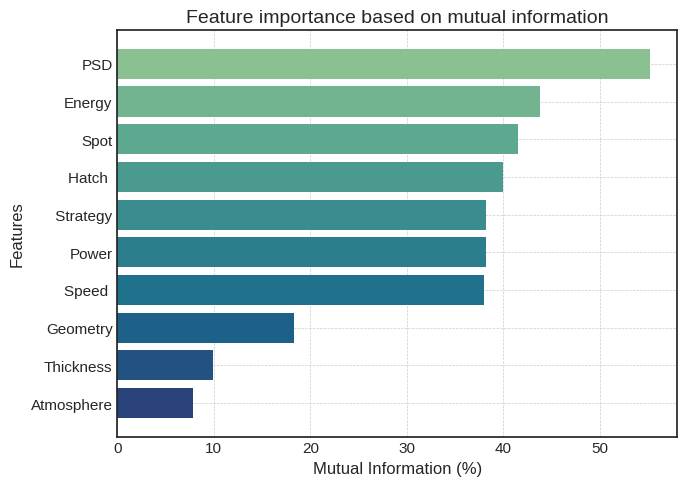

In [10]:
# Plotting
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11

import seaborn as sns

plt.style.use('seaborn-v0_8-white')
palette = sns.color_palette("crest", len(mi_df))
plt.figure(figsize=(7, 5))
plt.barh(mi_df['Feature'], mi_df['Mutual Information']*100, color=palette)
plt.xlabel('Mutual Information (%)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature importance based on mutual information', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Setting inputs - output:

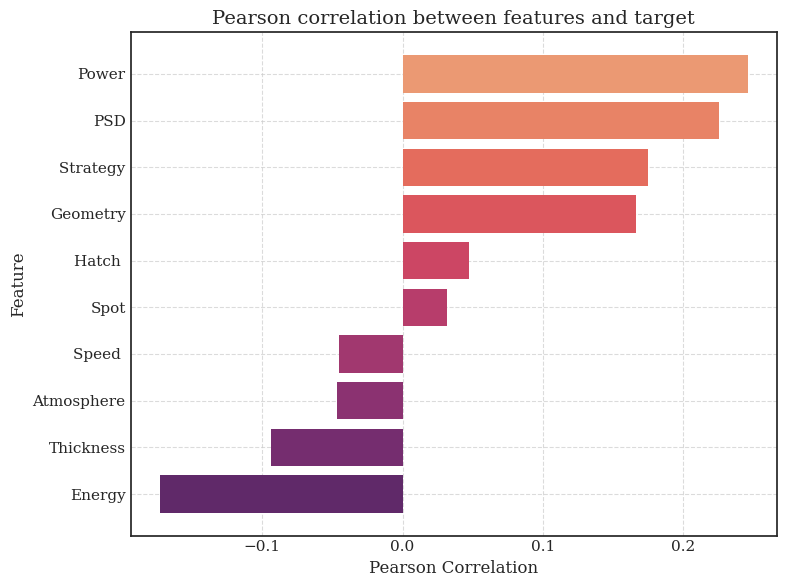

In [11]:
# Calculate the Pearson correlation between each feature and the target

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11

corr_matrix = df.corr()
corr_with_target = df.corr().iloc[:-1, -1]
corr_df = pd.DataFrame({'Feature': df.columns[:-1],
                        'Pearson Correlation': corr_with_target}).sort_values(by='Pearson Correlation', ascending=False)
fig, ax = plt.subplots(1,  figsize=(8, 6))
plt.style.use('seaborn-v0_8-white')

# --- Plot 1: Correlation Matrix Heatmap ---
#cmap = sns.diverging_palette(220, 20, as_cmap=True)
#sns.heatmap(corr_matrix, annot=True, cmap=cmap, ax=ax[0], fmt='.2f', cbar_kws={'shrink': .8}, vmin=-1, vmax=1)
#ax[0].set_title('Pearson Correlation Matrix', fontsize=14)

# --- Plot 2: Bar Chart of Pearson Correlation with Target ---
palette = sns.color_palette("flare", len(corr_df))
ax.barh(corr_df['Feature'], corr_df['Pearson Correlation'], color=palette)
ax.set_xlabel('Pearson Correlation', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Pearson correlation between features and target', fontsize=14)
ax.invert_yaxis()
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('pearson2.png', dpi=300)

plt.show()

In [12]:
#X=data[['P', 'S', 'L',  'HD1',  'F', 'd' ]]
X=data[['Power', 'Speed ', 'Hatch ',  'Thickness', 'Spot', 'Energy', 'PSD', 'Atmosphere', 'Geometry', ' Strategy']]
Y = data['RD'].values.reshape(-1, 1)

# RD prediction

 Split data

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print('training samples:', X_train.shape[0],  ' test samples:', X_test.shape[0])

training samples: 272  test samples: 69


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#y_train = scaler.fit_transform(y_train)
#y_test = scaler.transform(y_test)


In [15]:
YTR=np.mean(y_train)
YTR

96.58613970588236

In [16]:
YT=np.mean(y_test)
YT

96.91739130434782

###Results:

In [17]:
from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle

In [18]:
from sklearn.metrics import mean_absolute_error as MAE
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None)
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

 98%|█████████▊| 41/42 [00:05<00:00,  7.73it/s]

XGBRegressor model failed to execute
'super' object has no attribute '__sklearn_tags__'
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 272, number of used features: 10
[LightGBM] [Info] Start training from score 96.586140
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

100%|██████████| 42/42 [00:05<00:00,  7.97it/s]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.83       0.85  1.29        0.32
KNeighborsRegressor                          0.82       0.84  1.33        0.02
ExtraTreeRegressor                           0.74       0.78  1.58        0.04
BaggingRegressor                             0.72       0.76  1.65        0.04
RandomForestRegressor                        0.72       0.76  1.65        0.53
GradientBoostingRegressor                    0.71       0.75  1.68        0.18
LGBMRegressor                                0.67       0.71  1.80        0.22
HistGradientBoostingRegressor                0.66       0.71  1.82        0.21
DecisionTreeRegressor                        0.56       0.62  2.07        0.04
NuSVR                                        0.51       0.58  2.17        0.09
SVR                                          0.49   

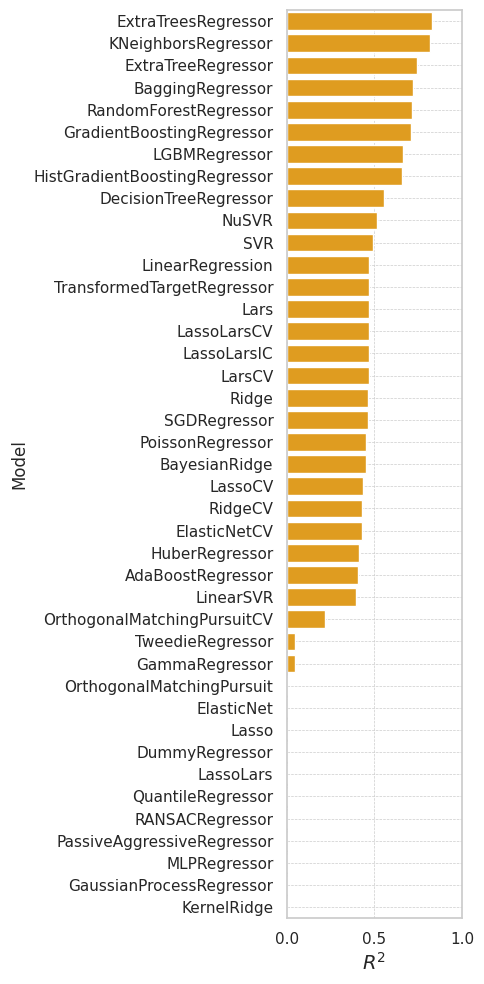

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'serif'
plt.style.use('seaborn-v0_8-white')
palette = sns.color_palette("crest", len(mi_df))
sns.set_theme(style="whitegrid")

predictions["R-Squared"] = [0 if i < 0 else i for i in predictions.iloc[:,0] ]
plt.figure(figsize=(5, 10))
palette = sns.color_palette("flare", len(corr_df))
ax = sns.barplot(y=predictions.index, x="R-Squared", data=predictions, color='orange')
ax.set(xlim=(0, 1))
plt.xlabel('$R^2$', fontsize=14)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.savefig('lazy2.png', dpi=300)

plt.show()

In [20]:
#---------Scikit-learn Utilities---------------------------------------------------------------------------------------------
from sklearn.metrics import r2_score as R2
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor

## ExtraTreesRegressor

In [21]:
from sklearn.ensemble import ExtraTreesRegressor
#KERNEL
#GBR=GradientBoostingRegressor(n_estimators=100, random_state=0)
ETR=ExtraTreesRegressor(n_estimators=1000, random_state=42 )

#START TRAINING
ETR.fit(X_train, y_train)
#PREDICTION
y_train_pred = ETR.predict(X_train)
y_test_pred = ETR.predict(X_test)

y_pred_train = ETR.predict(X_train)
y_pred_test = ETR.predict(X_test)

MSE_train = MSE(y_train, y_train_pred)
MSE_test = MSE(y_test, y_test_pred)
r2_train = R2(y_train, y_train_pred)
r2_test = R2(y_test, y_test_pred)
mae_train = MAE(y_train, y_train_pred)
mae_test = MAE(y_test, y_test_pred)

print('-'*100)
print(f'Error Metrics')
print(f'Training: MAE={mae_train:.4f}, MSE={MSE_train:.4f}, R2={r2_train:.4f}')
print(f'Testing: MAE={mae_test:.4f}, MSE={MSE_test:.4f}, R2={r2_test:.4f}')
print('-'*100)

----------------------------------------------------------------------------------------------------
Error Metrics
Training: MAE=0.1696, MSE=0.5082, R2=0.9531
Testing: MAE=0.6393, MSE=1.5966, R2=0.8587
----------------------------------------------------------------------------------------------------


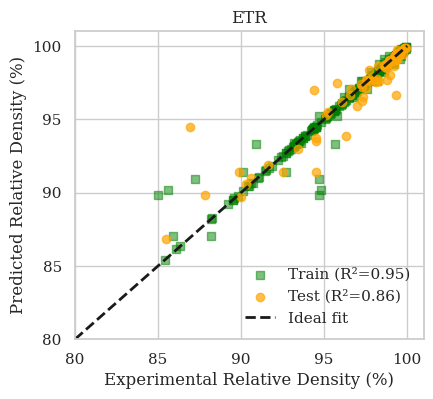

In [22]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11

fig, axes = plt.subplots(1, 1, figsize=(4.5, 4), sharex=True, sharey=True)

ax = axes
ax.scatter(y_train, y_pred_train, label=f"Train (R²={r2_train:.2f})", alpha=0.5, color='green' , marker='s')
ax.scatter(y_test, y_pred_test, label=f"Test (R²={r2_test:.2f})", alpha=0.7, color='orange')
ax.plot([80, 100], [80, 100], 'k--', lw=2, label='Ideal fit')

ax.set_title("ETR")
ax.set_xlabel("Experimental Relative Density (%)")
ax.set_ylabel("Predicted Relative Density (%)")

ax.set_ylim(80, 101)
ax.set_xlim(80, 101)
ax.set_yticks(range(80, 101, 5))
ax.set_xticks(range(80, 101, 5))
ax.legend(loc='lower right')

plt.savefig('ETR2.png', dpi=300)
plt.show()

## KNeighborsRegressor

In [23]:
from sklearn.neighbors import KNeighborsRegressor
#KERNEL
#GBR=GradientBoostingRegressor(n_estimators=100, random_state=0)
KNR=KNeighborsRegressor(n_neighbors=2 )

#START TRAINING
KNR.fit(X_train, y_train)
#PREDICTION
y_train_pred = KNR.predict(X_train)
y_test_pred = KNR.predict(X_test)

y_pred_train = KNR.predict(X_train)
y_pred_test = KNR.predict(X_test)

MSE_train = MSE(y_train, y_train_pred)
MSE_test = MSE(y_test, y_test_pred)
r2_train = R2(y_train, y_train_pred)
r2_test = R2(y_test, y_test_pred)
mae_train = MAE(y_train, y_train_pred)
mae_test = MAE(y_test, y_test_pred)

print('-'*100)
print(f'Error Metrics')
print(f'Training: MAE={mae_train:.4f}, MSE={MSE_train:.4f}, R2={r2_train:.4f}')
print(f'Testing: MAE={mae_test:.4f}, MSE={MSE_test:.4f}, R2={r2_test:.4f}')
print('-'*100)

----------------------------------------------------------------------------------------------------
Error Metrics
Training: MAE=0.5844, MSE=1.2248, R2=0.8869
Testing: MAE=0.6725, MSE=1.4216, R2=0.8742
----------------------------------------------------------------------------------------------------


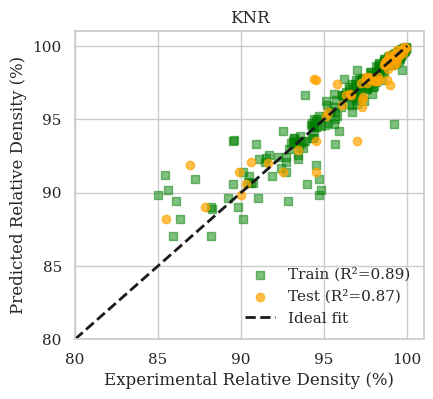

In [24]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11

fig, axes = plt.subplots(1, 1, figsize=(4.5, 4), sharex=True, sharey=True)

ax = axes
ax.scatter(y_train, y_pred_train, label=f"Train (R²={r2_train:.2f})", alpha=0.5, color='green' , marker='s')
ax.scatter(y_test, y_pred_test, label=f"Test (R²={r2_test:.2f})", alpha=0.7, color='orange')
ax.plot([80, 100], [80, 100], 'k--', lw=2, label='Ideal fit')

ax.set_title("KNR")
ax.set_xlabel("Experimental Relative Density (%)")
ax.set_ylabel("Predicted Relative Density (%)")

ax.set_ylim(80, 101)
ax.set_xlim(80, 101)
ax.set_yticks(range(80, 101, 5))
ax.set_xticks(range(80, 101, 5))
ax.legend(loc='lower right')

plt.savefig('KNR2.png', dpi=300)
plt.show()

### XGB

In [25]:
import pickle
import xgboost as xgb

# Change missing=None to missing=np.nan
# Assuming you want to use np.nan for missing values
import numpy as np

xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             min_child_weight=1, missing=np.nan, n_estimators=1000, # Changed missing value to np.nan
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

In [26]:
y_train_pred = xgbr.predict(X_train)
y_test_pred = xgbr.predict(X_test)

y_pred_train = xgbr.predict(X_train)
y_pred_test = xgbr.predict(X_test)

MSE_train = MSE(y_train, y_train_pred)
MSE_test = MSE(y_test, y_test_pred)
r2_train = R2(y_train, y_train_pred)
r2_test = R2(y_test, y_test_pred)
mae_train = MAE(y_train, y_train_pred)
mae_test = MAE(y_test, y_test_pred)

print('-'*100)
print(f'Error Metrics')
print(f'Training: MAE={mae_train:.4f}, MSE={MSE_train:.4f}, R2={r2_train:.4f}')
print(f'Testing: MAE={mae_test:.4f}, MSE={MSE_test:.4f}, R2={r2_test:.4f}')
print('-'*100)

----------------------------------------------------------------------------------------------------
Error Metrics
Training: MAE=0.1708, MSE=0.5082, R2=0.9531
Testing: MAE=0.8586, MSE=2.2586, R2=0.8001
----------------------------------------------------------------------------------------------------


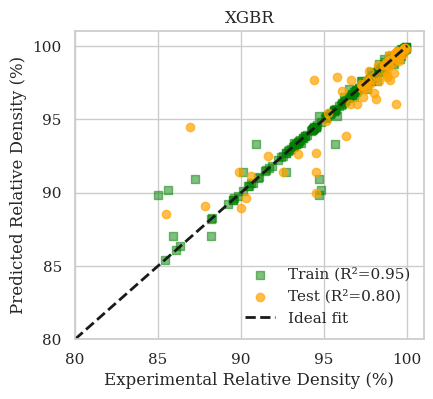

In [27]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11

fig, axes = plt.subplots(1, 1, figsize=(4.5, 4), sharex=True, sharey=True)

ax = axes
ax.scatter(y_train, y_pred_train, label=f"Train (R²={r2_train:.2f})", alpha=0.5, color='green', marker='s')
ax.scatter(y_test, y_pred_test, label=f"Test (R²={r2_test:.2f})", alpha=0.7, color='orange')
ax.plot([80, 100], [80, 100], 'k--', lw=2, label='Ideal fit')

ax.set_title("XGBR")
ax.set_xlabel("Experimental Relative Density (%)")
ax.set_ylabel("Predicted Relative Density (%)")

ax.set_ylim(80, 101)
ax.set_xlim(80, 101)
ax.set_yticks(range(80, 101, 5))
ax.set_xticks(range(80, 101, 5))
ax.legend(loc='lower right')

plt.savefig('XGBR2.png', dpi=300)
plt.show()

In [28]:
# get importance

importance = xgbr.feature_importances_
# summarize feature importance

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance


Feature: 0, Score: 0.09334
Feature: 1, Score: 0.07165
Feature: 2, Score: 0.06148
Feature: 3, Score: 0.07821
Feature: 4, Score: 0.18507
Feature: 5, Score: 0.09442
Feature: 6, Score: 0.20449
Feature: 7, Score: 0.16927
Feature: 8, Score: 0.00001
Feature: 9, Score: 0.04207


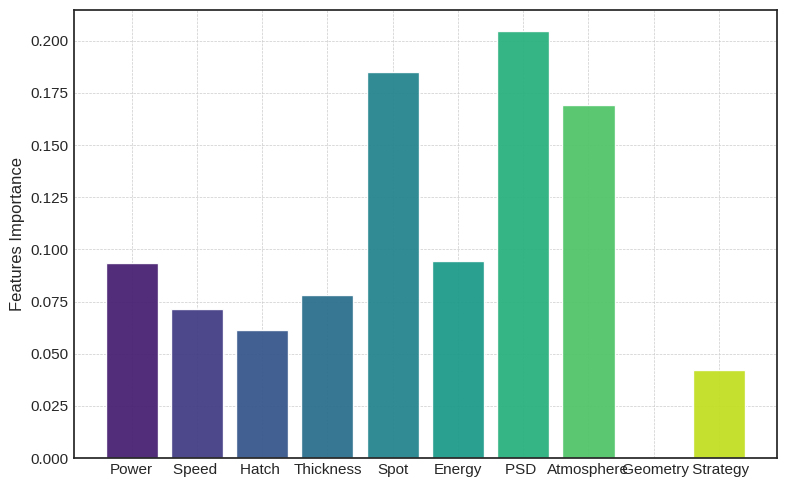

In [29]:
# Create lists for the plot
import seaborn as sns
plt.style.use('seaborn-v0_8-white')
palette = sns.color_palette("viridis", len(mi_df))

labels = ['Power', 'Speed ', 'Hatch ',  'Thickness', 'Spot', 'Energy', 'PSD ', 'Atmosphere', ' Geometry', ' Strategy']
x_pos = np.arange(len(labels))

fig, ax = plt.subplots()
fig.set_size_inches((8,5))

ax.bar(x_pos, importance, align='center', alpha=0.95, color=palette)
ax.set_ylabel('Features Importance')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
#ax.set_title('Features Importance Analysis')
ax.yaxis.grid(True)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


## RFR

In [30]:
from sklearn.ensemble import RandomForestRegressor
#KERNEL
RFR=RandomForestRegressor(n_estimators=2000)

#START TRAINING
RFR.fit(X_train,y_train)
#PREDICTION

y_train_pred = RFR.predict(X_train)
y_test_pred = RFR.predict(X_test)

y_pred_train = RFR.predict(X_train)
y_pred_test = RFR.predict(X_test)

MSE_train = MSE(y_train, y_train_pred)
MSE_test = MSE(y_test, y_test_pred)
r2_train = R2(y_train, y_train_pred)
r2_test = R2(y_test, y_test_pred)
mae_train = MAE(y_train, y_train_pred)
mae_test = MAE(y_test, y_test_pred)

print('-'*100)
print(f'Error Metrics')
print(f'Training: MAE={mae_train:.4f}, MSE={MSE_train:.4f}, R2={r2_train:.4f}')
print(f'Testing: MAE={mae_test:.4f}, MSE={MSE_test:.4f}, R2={r2_test:.4f}')
print('-'*100)

----------------------------------------------------------------------------------------------------
Error Metrics
Training: MAE=0.3947, MSE=0.7269, R2=0.9329
Testing: MAE=0.8045, MSE=2.6362, R2=0.7667
----------------------------------------------------------------------------------------------------


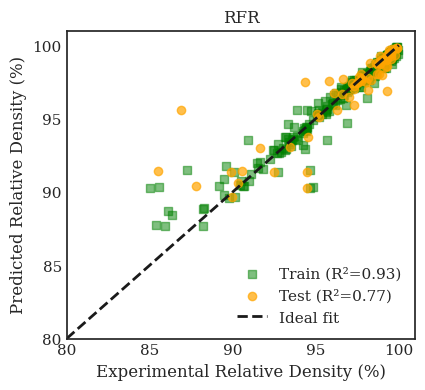

In [31]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11

fig, axes = plt.subplots(1, 1, figsize=(4.5, 4), sharex=True, sharey=True)

ax = axes
ax.scatter(y_train, y_pred_train, label=f"Train (R²={r2_train:.2f})", alpha=0.5, color='green', marker='s')
ax.scatter(y_test, y_pred_test, label=f"Test (R²={r2_test:.2f})", alpha=0.7, color='orange')
ax.plot([80, 100], [80, 100], 'k--', lw=2, label='Ideal fit')

ax.set_title("RFR")
ax.set_xlabel("Experimental Relative Density (%)")
ax.set_ylabel("Predicted Relative Density (%)")

ax.set_ylim(80, 101)
ax.set_xlim(80, 101)
ax.set_yticks(range(80, 101, 5))
ax.set_xticks(range(80, 101, 5))
ax.legend(loc='lower right')

plt.show()

### CROSS-VALIDATION

In [32]:

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score as CV

import warnings
warnings.filterwarnings('ignore')

models = [ETR, KNR, xgbr,  RFR ]
labels = ['ETR', 'KNR', 'XGBR', 'RFR']
IMS = []

print("--------------------------------------------------------------")
print("%5s | %5s | %5s | %5s | %5s " % ("ML algorithm",  "CV-R2", "CV-MSE", "CV-MAE", "IM"))
print("--------------------------------------------------------------")

for mod, label in zip( models, labels):
  #y_star = mod.predict(X)

  scoreR2 = CV(mod, X_train, y_train, cv=10, scoring='r2')
  #print(-1*scoreR2)
  scoreMSE = CV(mod, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
  #print(-1*scoreMSE)
  scoreMAE = CV(mod, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
  #print(-1*scoreMAE)
  IM=np.sqrt(((1-scoreR2)**2) + (scoreMSE) + (scoreMAE**2) )
  #print("IM: ", IM)


  print("%15s | %.4f | %.4f | %.4f | %.4f " % (label,  scoreR2.mean(), -1*scoreMSE.mean(), -1*scoreMAE.mean() , np.sqrt(((1-scoreR2.mean())**2) + (-1*scoreMSE.mean()) + (scoreMAE.mean()**2) )))
print("--------------------------------------------------------------")

--------------------------------------------------------------
ML algorithm | CV-R2 | CV-MSE | CV-MAE |    IM 
--------------------------------------------------------------
            ETR | 0.6438 | 3.4329 | 0.8759 | 2.0802 
            KNR | 0.5158 | 4.9545 | 1.2051 | 2.5771 


AttributeError: 'super' object has no attribute '__sklearn_tags__'

# Deep learning

## PYTORCH

In [33]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

print(tf.__version__)

2.17.1


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim

In [35]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [36]:
# Define the model
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(10, 20),  # 3 input features, 64 hidden units
            nn.ReLU(),
            nn.Linear(20, 100),
            nn.ReLU(),
            nn.Linear(100, 64),
            nn.ReLU(),

            nn.Linear(64, 1)   # 1 output
        )

    def forward(self, x):
        return self.layers(x)

model = RegressionModel()

In [37]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [38]:
# Training loop
epochs = 1000
for epoch in range(epochs):
    # Forward pass
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate the model
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    predictions_test = model(X_test_tensor)
    test_loss = criterion(predictions_test, y_test_tensor)
    print(f"Test Loss: {test_loss.item():.4f}")

Epoch 50/1000, Loss: 7561.5513
Epoch 100/1000, Loss: 916.2242
Epoch 150/1000, Loss: 194.2889
Epoch 200/1000, Loss: 91.7125
Epoch 250/1000, Loss: 54.3678
Epoch 300/1000, Loss: 34.3378
Epoch 350/1000, Loss: 23.3989
Epoch 400/1000, Loss: 17.1735
Epoch 450/1000, Loss: 13.6815
Epoch 500/1000, Loss: 11.5368
Epoch 550/1000, Loss: 10.2107
Epoch 600/1000, Loss: 9.2533
Epoch 650/1000, Loss: 8.5271
Epoch 700/1000, Loss: 7.9414
Epoch 750/1000, Loss: 7.4069
Epoch 800/1000, Loss: 6.9431
Epoch 850/1000, Loss: 6.5484
Epoch 900/1000, Loss: 6.2056
Epoch 950/1000, Loss: 5.8959
Epoch 1000/1000, Loss: 5.6053
Test Loss: 13.3458


In [39]:
# Switch the model to evaluation mode
model.eval()

RegressionModel(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [40]:
# Make predictions
with torch.no_grad():
    predictions = model(X_test_tensor)

In [41]:
#PREDICTION

y_train_predT = model(X_train_tensor)
y_test_predT = model(X_test_tensor)

In [42]:
y_train_pred = y_train_predT.detach().numpy()
y_test_pred = y_test_predT.detach().numpy()


In [43]:
MSE_train = MSE(y_train, y_train_pred)
MSE_test = MSE(y_test, y_test_pred)
r2_train = R2(y_train, y_train_pred)
r2_test = R2(y_test, y_test_pred)
mae_train = MAE(y_train, y_train_pred)
mae_test = MAE(y_test, y_test_pred)

print('-'*100)
print(f'Error Metrics')
print(f'Training: MAE={mae_train:.4f}, MSE={MSE_train:.4f}, R2={r2_train:.4f}')
print(f'Testing: MAE={mae_test:.4f}, MSE={MSE_test:.4f}, R2={r2_test:.4f}')
print('-'*100)

----------------------------------------------------------------------------------------------------
Error Metrics
Training: MAE=1.6728, MSE=5.5998, R2=0.4827
Testing: MAE=2.0654, MSE=13.3458, R2=-0.1809
----------------------------------------------------------------------------------------------------


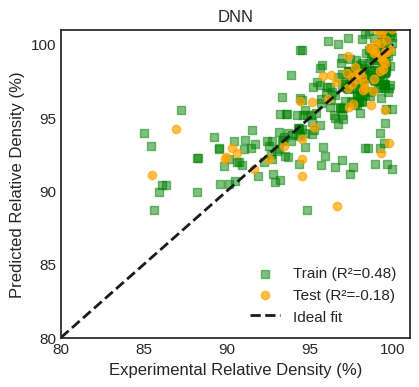

In [44]:
# Plotting
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11

import seaborn as sns

plt.style.use('seaborn-v0_8-white')
palette = sns.color_palette("crest", len(mi_df))


fig, axes = plt.subplots(1, 1, figsize=(4.5, 4), sharex=True, sharey=True)

ax = axes
ax.scatter(y_train, y_train_pred, label=f"Train (R²={r2_train:.2f})", alpha=0.5, color='green' , marker='s')
ax.scatter(y_test, y_test_pred, label=f"Test (R²={r2_test:.2f})", alpha=0.7, color='orange')
ax.plot([80, 100], [80, 100], 'k--', lw=2, label='Ideal fit')

ax.set_title("DNN")
ax.set_xlabel("Experimental Relative Density (%)")
ax.set_ylabel("Predicted Relative Density (%)")

ax.set_ylim(80, 101)
ax.set_xlim(80, 101)
ax.set_yticks(range(80, 101, 5))
ax.set_xticks(range(80, 101, 5))
ax.legend(loc='lower right')

#plt.savefig('DNN.png', dpi=300)
plt.show()

## **SHAP**

In [45]:
import shap
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.inspection import permutation_importance

In [49]:
def calculate_shap_values(models, weights, X, feature_names):
  if weights is None:
    shap_func = lambda x: models.predict(x)

  explainer = shap.Explainer(shap_func, X)
  shap_values = explainer(X)

  # SHAP Summary Plot

  plt.rcParams['font.family'] = 'serif'
  plt.rcParams['font.size'] = 11

  shap.summary_plot(shap_values, X, feature_names=feature_names, show=False)
  plt.savefig("SHAP_1.png", dpi=300)
  plt.show()
  plt.close()


  mean_shap_values = np.abs(shap_values.values).mean(axis=0)
  #shap_percent_contrib = mean_shap_values/(np.sum(mean_shap_values))*100
  sorted_indices = np.argsort(mean_shap_values)
  sorted_features = np.array(feature_names)[sorted_indices]
  sorted_mean_shap_values = mean_shap_values[sorted_indices]

  cmap = plt.get_cmap('viridis')
  colors = cmap(np.linspace(0, 1, len(sorted_features)))

  # SHAP BAR GRAPH
  plt.figure(figsize=(8,5))
  bars = plt.barh(sorted_features, sorted_mean_shap_values, color=colors, alpha=0.9)
  plt.xlabel("Mean Absolute Shapley Value")
  plt.ylabel("Features")
  #plt.xlim(0,31)
  for bar, value in zip(bars, sorted_mean_shap_values):
     plt.text(bar.get_width() + 0.01,
              bar.get_y() + bar.get_height() / 2,
              f"{value:.2f}",
              va='center',
              ha='left',
              fontsize=9)

  plt.tight_layout()

  plt.show()

In [50]:
feature_names = X.columns
random_indices = np.random.choice(X_train.shape[0], size=100, replace=False)
X_sample = X_train[random_indices, :]

ExactExplainer explainer: 101it [04:42,  2.91s/it]


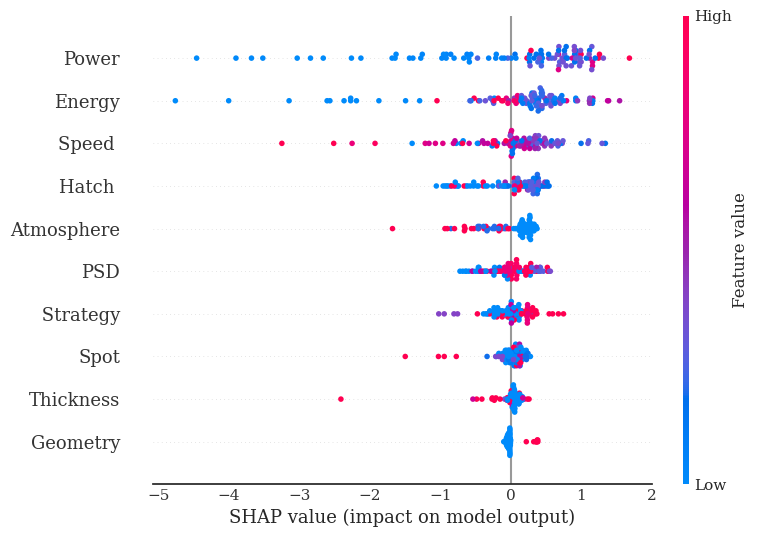

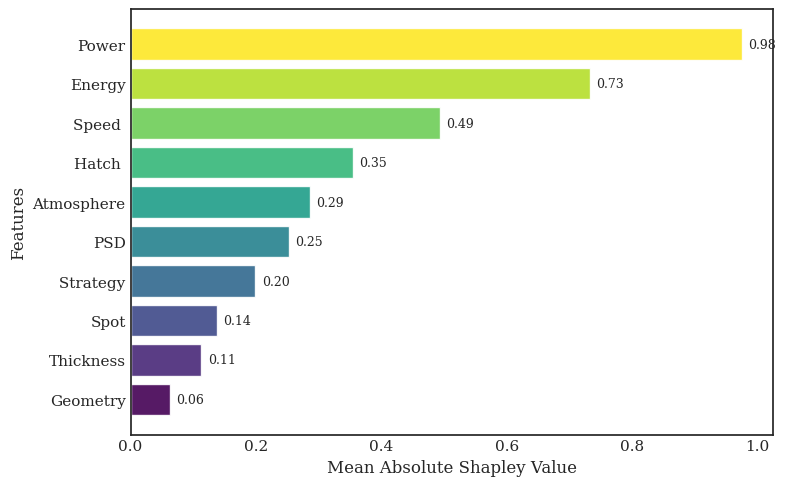

In [51]:
calculate_shap_values(ETR, None, X_sample, feature_names)